In [37]:
import duckdb
import pyarrow.parquet as pq
import pandas as pd

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [39]:
con = duckdb.connect()

parq = "noNull.parquet"

In [40]:
def get_purchase_helpfulness():
    """
    Compares average helpful votes for purchased vs. free reviews.
    """
    query = f"""
    SELECT
        steam_purchase,
        AVG(votes_up) AS avg_helpful_votes,
        COUNT(*) AS total_reviews
    FROM {parq}
    WHERE votes_up IS NOT NULL
    GROUP BY steam_purchase
    ORDER BY steam_purchase
    """
    return con.execute(query).fetchdf()

df_why1 = get_purchase_helpfulness()
df_why1


,steam_purchase,avg_helpful_votes,total_reviews
0,0,2.204534,37719573
1,1,2.338048,73658878


/var/folders/nb/9vq11ylj5l5715vrvc8fj0b00000gn/T/ipykernel_28944/2682885894.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='steam_purchase', y='avg_helpful_votes', palette=['orange','blue'])


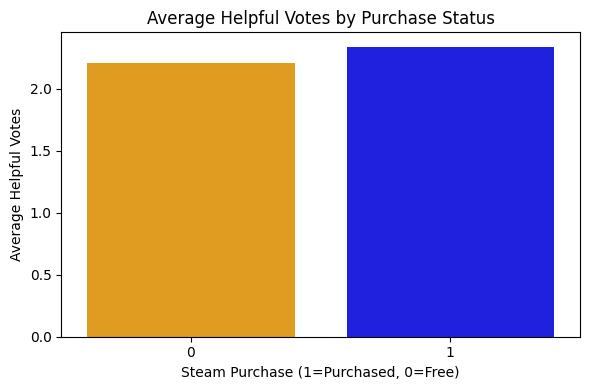

In [41]:
def plot_purchase_helpfulness(df):
    plt.figure(figsize=(6,4))
    sns.barplot(data=df, x='steam_purchase', y='avg_helpful_votes', palette=['orange','blue'])
    plt.title("Average Helpful Votes by Purchase Status")
    plt.xlabel("Steam Purchase (1=Purchased, 0=Free)")
    plt.ylabel("Average Helpful Votes")
    plt.tight_layout()
    plt.show()

plot_purchase_helpfulness(df_why1)


In [43]:
def get_same_games_helpfulness():
    """
    Returns the average helpful votes and total review counts
    for each game, split by purchase status,
    but ONLY for games that have at least one purchased AND one free review.
    """
    query = f"""
    WITH same_games AS (
        SELECT
            game
        FROM {parq}
        GROUP BY game
        HAVING
            -- This ensures each game has at least one purchased (steam_purchase=1) 
            -- AND at least one free (steam_purchase=0) review.
            SUM(CASE WHEN steam_purchase = 1 THEN 1 ELSE 0 END) > 0
            AND SUM(CASE WHEN steam_purchase = 0 THEN 1 ELSE 0 END) > 0
    )
    SELECT
        game,
        steam_purchase,
        AVG(votes_up) AS avg_helpful,
        COUNT(*) AS total_reviews
    FROM {parq}
    WHERE game IN (SELECT game FROM same_games)
      AND votes_up IS NOT NULL
    GROUP BY game, steam_purchase
    ORDER BY game, steam_purchase
    """
    return con.execute(query).fetchdf()

df_same = get_same_games_helpfulness()
df_same


,game,steam_purchase,avg_helpful,total_reviews
0,ACE COMBAT™ 7: SKIES UNKNOWN - F-15 S/MTD Set,0,20.000000,1
1,ACE COMBAT™ 7: SKIES UNKNOWN - F-15 S/MTD Set,1,5.800000,25
2,Arcade Sundown,0,2.571429,7
3,Arcade Sundown,1,1.838710,31
4,Castle of Full Moon 月圆之堡,0,3.076923,13
...,...,...,...,...
123119,🔴 Circles,1,3.125000,56
123120,🕌魔塔与6️⃣勇者 (Six Braves),0,1.812000,500
123121,🕌魔塔与6️⃣勇者 (Six Braves),1,7.000000,5
123122,🧠 OUT OF THE BOX,0,2.569231,65


In [11]:
len(df_same)

123124

In [45]:
df_pivot = df_same.pivot(
    index='game',
    columns='steam_purchase',
    values='avg_helpful'
).reset_index()


df_pivot.rename(columns={0: 'Avg_Free', 1: 'Avg_Purchased'}, inplace=True)

df_pivot['difference'] = df_pivot['Avg_Purchased'] - df_pivot['Avg_Free']

df_pivot


steam_purchase,game,Avg_Free,Avg_Purchased,difference
0,ACE COMBAT™ 7: SKIES UNKNOWN - F-15 S/MTD Set,20.000000,5.800000,-14.200000
1,Arcade Sundown,2.571429,1.838710,-0.732719
2,Castle of Full Moon 月圆之堡,3.076923,1.181818,-1.895105
3,Chamber of the Sci-Mutant Priestess,2.285714,3.166667,0.880952
4,DARK SOULS™ II Crown of the Ivory King,7.770492,4.932886,-2.837606
...,...,...,...,...
61557,～Daydream～蝶が舞う頃に,3.444444,3.793893,0.349449
61558,🐰RabbiruN🐰,0.833333,2.380952,1.547619
61559,🔴 Circles,1.087379,3.125000,2.037621
61560,🕌魔塔与6️⃣勇者 (Six Braves),1.812000,7.000000,5.188000


In [46]:
len(df_pivot)

61562

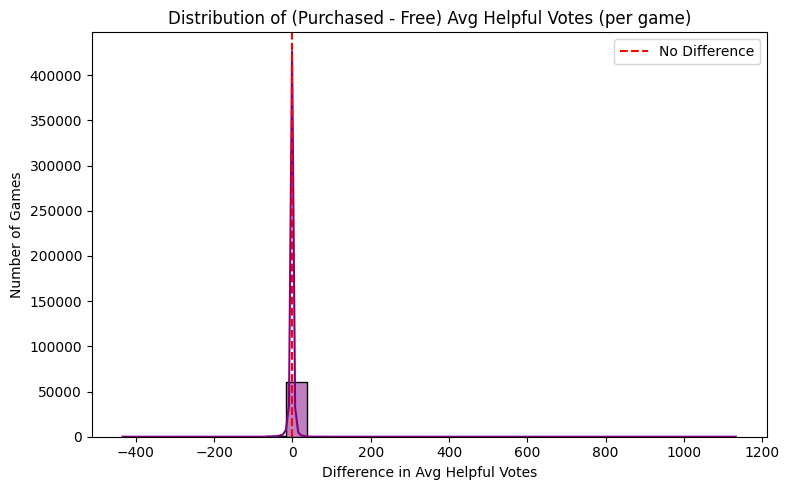

In [47]:
def plot_difference_distribution(df):
    plt.figure(figsize=(8,5))
    sns.histplot(df['difference'], bins=30, kde=True, color='purple')
    plt.title("Distribution of (Purchased - Free) Avg Helpful Votes (per game)")
    plt.xlabel("Difference in Avg Helpful Votes")
    plt.ylabel("Number of Games")
    plt.axvline(0, color='red', linestyle='--', label="No Difference")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_difference_distribution(df_pivot)


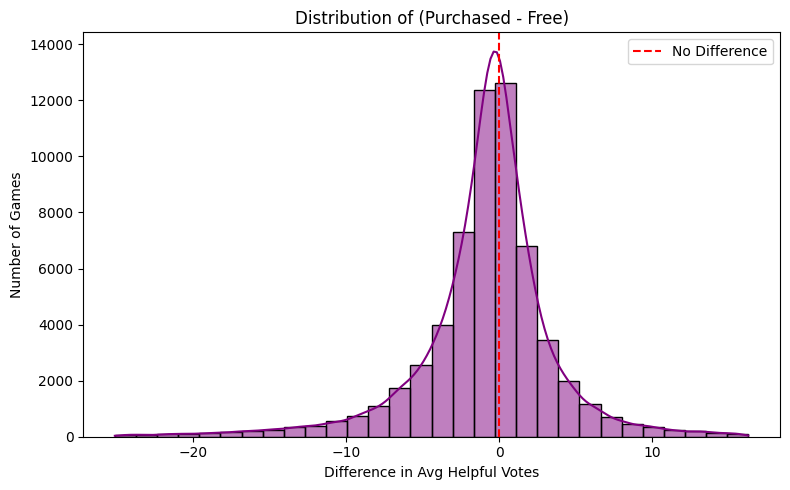

In [52]:
def plot_difference_distribution_clipped(df):
    """
    Plots the distribution of (Purchased - Free) average helpful votes, 
    removing extreme outliers (below 1st percentile or above 99th percentile).
    """

    # Calculate clipping thresholds
    q1 = df['difference'].quantile(0.01)   # 1st percentile
    q99 = df['difference'].quantile(0.99)  # 99th percentile
    
    # Filter out values outside [q1, q99]
    df_clipped = df[(df['difference'] >= q1) & (df['difference'] <= q99)]

    plt.figure(figsize=(8,5))
    sns.histplot(df_clipped['difference'], bins=30, kde=True, color='purple')
    plt.title("Distribution of (Purchased - Free)")
    plt.xlabel("Difference in Avg Helpful Votes")
    plt.ylabel("Number of Games")
    plt.axvline(0, color='red', linestyle='--', label="No Difference")
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_difference_distribution_clipped(df_pivot)


In [54]:

df_top_diff = df_pivot.sort_values('difference', ascending=False)
df_top_diff 




steam_purchase,game,Avg_Free,Avg_Purchased,difference
35738,Ottoman Empire: Spectacular Millennium,46.840000,1179.857143,1133.017143
53158,Total Ski Jump,8.000000,451.500000,443.500000
10449,Corporated Robots Wars,54.000000,479.500000,425.500000
21455,Grand Prix Racing On Line,11.000000,420.000000,409.000000
39172,Quicken WillMaker & Trust 2020,91.000000,463.000000,372.000000
...,...,...,...,...
1036,ADR-Labelling Game,344.500000,114.615385,-229.884615
55528,VR Bukkake,242.000000,8.142857,-233.857143
17610,FaceFun,467.000000,111.086957,-355.913043
1746,After School Massacre,368.000000,6.000000,-362.000000


In [20]:
len(df_top_diff)

61562

In [55]:
df_bottom_diff = df_pivot.sort_values('difference', ascending=True)
df_bottom_diff

steam_purchase,game,Avg_Free,Avg_Purchased,difference
50643,The Hidden and Unknown,510.222222,76.333333,-433.888889
1746,After School Massacre,368.000000,6.000000,-362.000000
17610,FaceFun,467.000000,111.086957,-355.913043
55528,VR Bukkake,242.000000,8.142857,-233.857143
1036,ADR-Labelling Game,344.500000,114.615385,-229.884615
...,...,...,...,...
39172,Quicken WillMaker & Trust 2020,91.000000,463.000000,372.000000
21455,Grand Prix Racing On Line,11.000000,420.000000,409.000000
10449,Corporated Robots Wars,54.000000,479.500000,425.500000
53158,Total Ski Jump,8.000000,451.500000,443.500000


In [23]:
len(df_bottom_diff)

61562

In [56]:

df_positive = df_pivot[df_pivot['difference'] > 0].copy()
df_negative = df_pivot[df_pivot['difference'] < 0].copy()
df_zero = df_pivot[df_pivot['difference'] == 0].copy()

df_positive.sort_values('difference', ascending=False, inplace=True)
df_negative.sort_values('difference', ascending=True, inplace=True)




print("Positive Differences (Purchased > Free):")
df_positive.sort_values('difference', ascending=True)





Positive Differences (Purchased > Free):


steam_purchase,game,Avg_Free,Avg_Purchased,difference
27196,Kings and Heroes,5.354167,5.354449,0.000283
58427,XIII,7.979592,7.980100,0.000508
21848,Guild Wars,0.173077,0.173591,0.000514
26556,Just King,1.831169,1.832054,0.000885
36679,Particulars,5.406250,5.407407,0.001157
...,...,...,...,...
39172,Quicken WillMaker & Trust 2020,91.000000,463.000000,372.000000
21455,Grand Prix Racing On Line,11.000000,420.000000,409.000000
10449,Corporated Robots Wars,54.000000,479.500000,425.500000
53158,Total Ski Jump,8.000000,451.500000,443.500000


In [57]:
df_negative.sort_values('difference', ascending=True)

steam_purchase,game,Avg_Free,Avg_Purchased,difference
50643,The Hidden and Unknown,510.222222,76.333333,-433.888889
1746,After School Massacre,368.000000,6.000000,-362.000000
17610,FaceFun,467.000000,111.086957,-355.913043
55528,VR Bukkake,242.000000,8.142857,-233.857143
1036,ADR-Labelling Game,344.500000,114.615385,-229.884615
...,...,...,...,...
23898,Hogwarts Legacy,1.548795,1.547837,-0.000957
51965,The Timeless Child,1.334071,1.333333,-0.000737
58960,Zen Garden,3.076923,3.076271,-0.000652
50137,The Deed,2.065678,2.065539,-0.000139


In [58]:
df_zero

steam_purchase,game,Avg_Free,Avg_Purchased,difference
53,*NEW* SCUFFED STARTER PACK,5.000000,5.000000,0.0
291,2 Synchro Hedgehogs,2.000000,2.000000,0.0
346,3 Days in the Abyss,1.000000,1.000000,0.0
445,3am in Leicester,0.000000,0.000000,0.0
479,4Team,1.333333,1.333333,0.0
...,...,...,...,...
61212,腾起之蛇,7.500000,7.500000,0.0
61298,謳歌的聖女,2.000000,2.000000,0.0
61381,都市物语 city story,1.000000,1.000000,0.0
61438,雾之本境S - 公式设定集,1.000000,1.000000,0.0


In [66]:
def plot_top_games_diff(df, top_n=30):
    # Take the top n games by absolute difference
    df_sub = df.assign(abs_diff=df['difference'].abs()).nlargest(top_n, 'abs_diff')
    
    # Melt for grouped bar chart
    df_melt = df_sub.melt(
        id_vars=['game', 'difference'],
        value_vars=['avg_helpful_free', 'avg_helpful_purchased'],
        var_name='review_type',
        value_name='avg_helpful'
    )
    
    plt.figure(figsize=(10,6))
    sns.barplot(
        data=df_melt,
        x='game', y='avg_helpful',
        hue='review_type'
    )
    plt.title(f"Top {top_n} Games by Biggest Difference (Purchased vs. Free)")
    plt.xlabel("Game")
    plt.ylabel("Average Helpful Votes")
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Review Type")
    plt.tight_layout()
    plt.show()

plot_top_games_diff(df_pivot)


KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['avg_helpful_free', 'avg_helpful_purchased']"

In [60]:
def get_top_3_games():
    query = f"""
    SELECT
        game,
        COUNT(*) AS total_reviews
    FROM {parq}
    GROUP BY game
    ORDER BY total_reviews DESC
    LIMIT 3
    """
    return con.execute(query).fetchdf()

df_top3 = get_top_3_games()
print(df_top3)


                  game  total_reviews
0     Counter-Strike 2        7704653
1  PUBG: BATTLEGROUNDS        2235431
2   Grand Theft Auto V        1659268


In [61]:
def get_time_chart_data(games_list):
    # Convert the list of games to a comma-separated string for SQL
    games_str = "', '".join(str(g) for g in games_list)
    
    query = f"""
    SELECT
        game,
        steam_purchase,
        DATE_TRUNC('month', timestamp_created) AS month,
        AVG(votes_up) AS avg_helpful,
        COUNT(*) AS total_reviews
    FROM {parq}
    WHERE game IN ('{games_str}')
      AND votes_up IS NOT NULL
    GROUP BY 1, 2, 3
    ORDER BY 1, 2, 3
    """
    return con.execute(query).fetchdf()

top3_games_list = df_top3['game'].tolist()  # e.g., ["Counter-Strike", "Dota 2", ...]
df_time = get_time_chart_data(top3_games_list)
print(df_time.head(10))


               game  steam_purchase      month  avg_helpful  total_reviews
0  Counter-Strike 2               0 2012-05-01    12.000000              1
1  Counter-Strike 2               0 2012-08-01     1.006438            466
2  Counter-Strike 2               0 2012-09-01     0.667606            355
3  Counter-Strike 2               0 2012-10-01     1.163265            196
4  Counter-Strike 2               0 2012-11-01     0.663507            211
5  Counter-Strike 2               0 2012-12-01     0.681481            270
6  Counter-Strike 2               0 2013-01-01     0.627273            220
7  Counter-Strike 2               0 2013-02-01     0.740000            200
8  Counter-Strike 2               0 2013-03-01     0.881188            202
9  Counter-Strike 2               0 2013-04-01     0.773869            199


In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

def plot_time_chart_stacked(df):
    df['month'] = pd.to_datetime(df['month'])

    g = sns.FacetGrid(
        df,
        col='game',
        hue='steam_purchase',
        col_wrap=1,     
        height=3,      
        aspect=4,         
        sharey=False
    )

    g.map(sns.lineplot, 'month', 'avg_helpful', marker='o').add_legend()

    for ax in g.axes.flatten():
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')

    g.set_xlabels("Month")
    g.set_ylabels("Avg Helpful Votes")
    g.fig.suptitle("Monthly Helpfulness (Purchased vs. Free)", y=1.05)
    
    plt.tight_layout()
    plt.show()


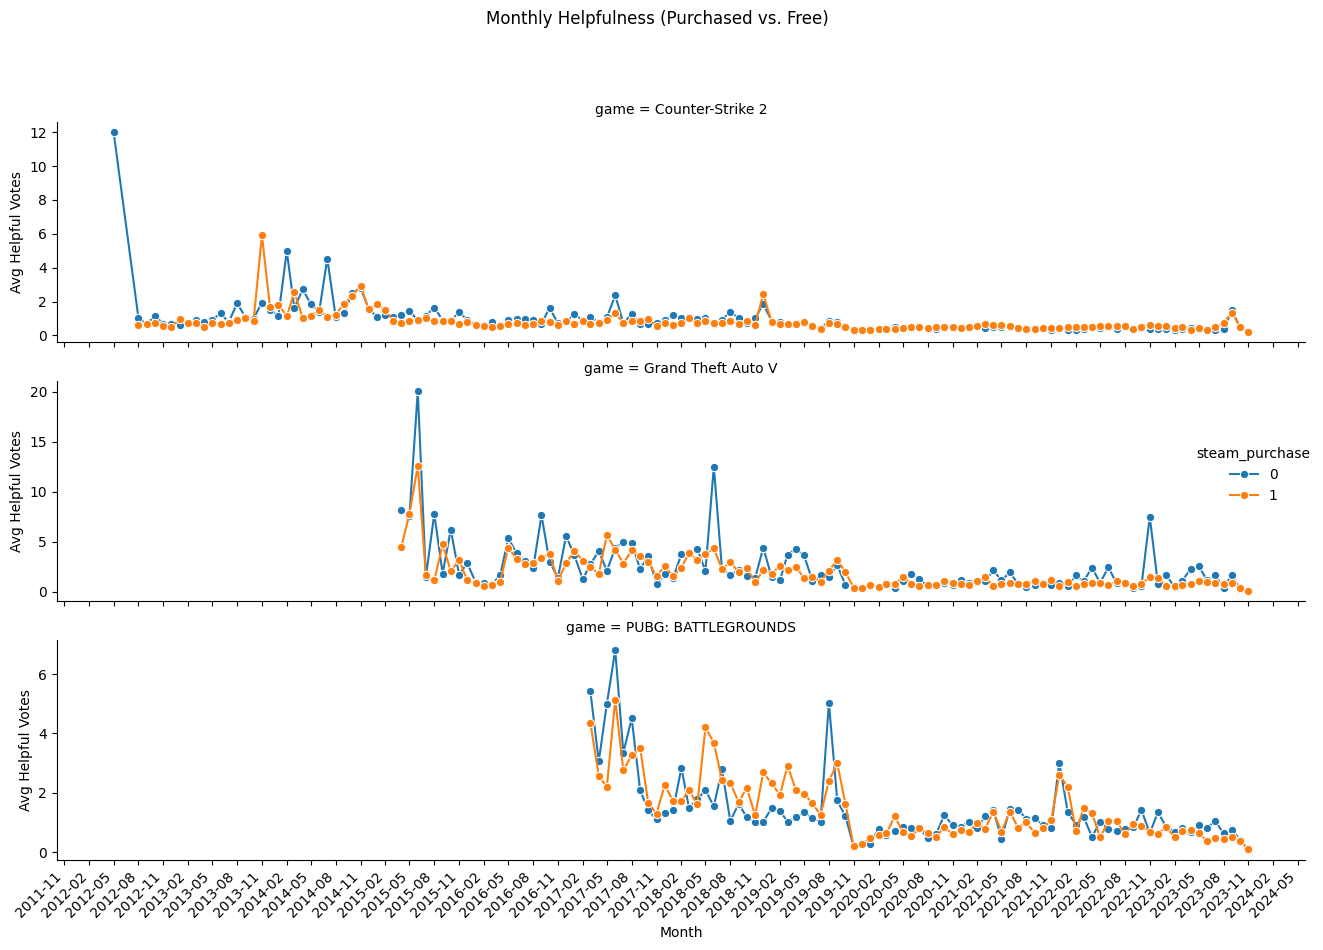

In [42]:
plot_time_chart_stacked(df_time)

In [68]:
def get_paid_games():
    query = f"""
    WITH paid_games AS (
        SELECT 
            game
        FROM {parq}
        GROUP BY game
        HAVING SUM(CASE WHEN steam_purchase = 1 THEN 1 ELSE 0 END) > 0
    )
    SELECT game FROM paid_games
    """
    return con.execute(query).fetchdf()

def get_helpfulness_for_paid_only(paid_game_list):
    # Turn game list into an IN clause
    games_str = "', '".join(str(g) for g in paid_game_list)
    query = f"""
    SELECT
        steam_purchase,
        AVG(votes_up) AS avg_helpful_votes,
        COUNT(*) AS total_reviews
    FROM {parq}
    WHERE game IN ('{games_str}')
      AND votes_up IS NOT NULL
    GROUP BY steam_purchase
    ORDER BY steam_purchase
    """
    return con.execute(query).fetchdf()

paid_games_df = get_paid_games()
paid_game_list = paid_games_df['game'].tolist()

df_paid_only = get_helpfulness_for_paid_only(paid_game_list)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(data=df_paid_only, x='steam_purchase', y='avg_helpful_votes', palette=['orange','blue'])
plt.title("Average Helpful Votes by Purchase Status (Paid Games Only)")
plt.xlabel("Steam Purchase (1=Purchased, 0=Free)")
plt.ylabel("Average Helpful Votes")
plt.tight_layout()
plt.show()


ParserException: Parser Error: syntax error at or near "s"